# 🧪 Experimento TwiBot-20 (Completo)

Validando a metodologia do artigo nos dados completos do TwiBot-20 (formato JSON), conforme o README.

**IMPORTANTE:** Este notebook assume que você substituiu `config.py`, `data_utils.py` (para `TwiBotDataLoader`) e `bias_calculator.py` (para ler `tweet_*.json`) pelas versões corretas.

## ⚙️ Passo 0: Configuração do Ambiente

In [1]:
# (Apenas para Colab - Pule se estiver rodando localmente)
# print("Montando Google Drive...")
# from google.colab import drive
# drive.mount('/content/drive')

import os
# (Edite para o seu caminho.)
project_path_on_drive = '..' 
os.chdir(project_path_on_drive)

print(f"Diretório de trabalho: {os.getcwd()}")

print("📦 Instalando e atualizando dependências...")
# (Use !pip3 no Colab, pip no local)
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu130 -q
!pip install --upgrade networkx python-louvain pandas tqdm psutil transformers[torch] matplotlib seaborn tabulate cvxpy -q
print("✅ Dependências instaladas!")

Diretório de trabalho: e:\Projetos\bias-aware-community-detection
📦 Instalando e atualizando dependências...
✅ Dependências instaladas!


In [2]:
print("🔧 Importando módulos e configurando ambiente...")

import sys
import time
import json
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as louvain
import warnings
import random
from collections import defaultdict

# Adicionar 'src' ao sys.path
project_dir_to_add = os.getcwd()
if project_dir_to_add not in sys.path:
    sys.path.append(project_dir_to_add)

# Importar nossos módulos (TwiBot-20 Completo)
try:
    from src.config import Config
    from src.data_utils import TwiBot20Loader # <-- Lendo JSON
    from src.bias_calculator import BiasCalculator # <-- Lendo JSON
    from src.heuristic import EnhancedLouvainWithBias 
    from src.evaluation import ComprehensiveEvaluator
except ImportError as e:
    print(f"❌ ERRO: Não foi possível importar os módulos. Verifique os arquivos .py.")
    print(f"Detalhe: {e}")
    raise e

cfg = Config()
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(cfg.RANDOM_STATE)
random.seed(cfg.RANDOM_STATE)

print("\n--- Verificação de Hardware ---")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU NÃO DETECTADA. Usando CPU.")
print(f"✅ CPUs: {os.cpu_count()} (Config.NUM_WORKERS={cfg.NUM_WORKERS})")
print(f"✅ Caminho de dados: {cfg.TWIBOT20_FILE}")
print("✅ Ambiente pronto!")

🔧 Importando módulos e configurando ambiente...

--- Verificação de Hardware ---
✅ GPU: NVIDIA GeForce RTX 3060
✅ CPUs: 12 (Config.NUM_WORKERS=10)
✅ Caminho de dados: e:\Projetos\bias-aware-community-detection\TwiBot-20\train.json
✅ Ambiente pronto!


## 📊 Passo 1: Carregar Grafo (TwiBot-20 Completo)

Carrega o grafo a partir do `train.json` (ou qualquer arquivo definido no `config.py`), lendo as chaves `ID`, `label` e `neighbor`.

In [3]:
import time

print("📊 Carregando/Construindo Grafo (TwiBot-20 Completo)...")
start_load = time.time()

data_loader = TwiBot20Loader()

# max_nodes=None para carregar o arquivo JSON completo
G, bot_labels = data_loader.load_and_build_graph(max_nodes=None)

load_time = time.time() - start_load
print(f"   ↳ Tempo total: {load_time:.2f}s")
print(f"\n📈 Grafo Carregado: {G.number_of_nodes():,} nós, {G.number_of_edges():,} arestas")
print(f"🎯 Bots Identificados: {sum(bot_labels.values()):,} ({sum(bot_labels.values())/len(bot_labels):.1%})")

📊 Carregando/Construindo Grafo (TwiBot-20 Completo)...
📊 Fase 1: Carregando/Construindo Grafo (TwiBot-20)...
   Arquivos de cache encontrados! Carregando...
   ✅ Grafo (cache): 4,327 nós, 5,393 arestas.
   ↳ Tempo total: 0.01s

📈 Grafo Carregado: 4,327 nós, 5,393 arestas
🎯 Bots Identificados: 2,108 (48.7%)


## 🧠 Passo 2: Calcular Scores de Viés (TwiBot-20 Completo)

Processa a lista de usuários em paralelo, lendo os tweets da chave `'tweet'` de cada um.

🧠 Calculando/Carregando Scores de Viés (TwiBot-20 Completo)...

🧠 Fase 2: Calculando/Carregando Scores de Viés (MODELO POLITICS)...
   Arquivo de cache 'e:\Projetos\bias-aware-community-detection\processed_data_tw20_json\tw20_bias_scores.json' encontrado! Carregando...
   ✅ Scores carregados para 4327 usuários.
   ↳ Tempo total: 0.00s

📊 Estatísticas do Viés (Nós com tweets: 4,291):
   Média=-0.170, Std=0.244


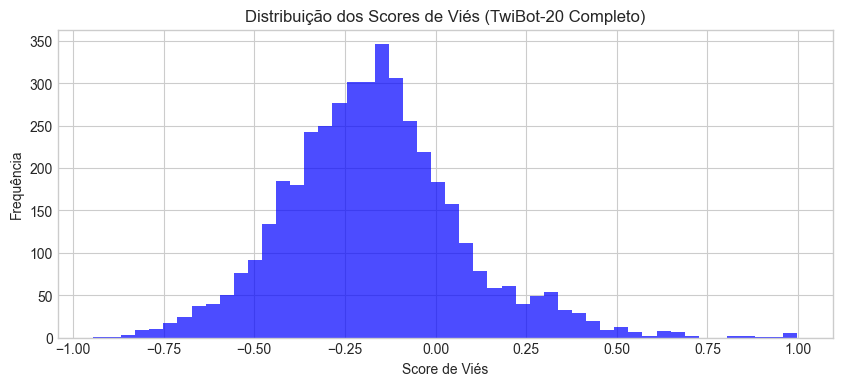

In [4]:
print("🧠 Calculando/Carregando Scores de Viés (TwiBot-20 Completo)...")
start_bias = time.time()

bias_calculator = BiasCalculator()

# Passa o SET de nós (strings) do grafo G
bias_scores = bias_calculator.get_or_calculate_bias_scores(set(G.nodes()))

bias_time = time.time() - start_bias
print(f"   ↳ Tempo total: {bias_time:.2f}s")

# Análise exploratória
bias_values = [s for s in bias_scores.values() if s != 0.0]
if bias_values:
    print(f"\n📊 Estatísticas do Viés (Nós com tweets: {len(bias_values):,}):")
    print(f"   Média={np.mean(bias_values):.3f}, Std={np.std(bias_values):.3f}")
    
    plt.figure(figsize=(10, 4))
    plt.hist(bias_values, bins=50, alpha=0.7, color='blue')
    plt.title('Distribuição dos Scores de Viés (TwiBot-20 Completo)')
    plt.xlabel('Score de Viés')
    plt.ylabel('Frequência')
    plt.show()
else:
    print("⚠️ Nenhum score de viés foi calculado (nenhum usuário tinha tweets?).")

## 🎯 Passo 3: Executar Heurística & Baseline

In [5]:
print(f"\n🎯 Executando Enhanced Louvain com Viés (α={cfg.ALPHA})...")
start_enhanced = time.time()
detector = EnhancedLouvainWithBias(alpha=cfg.ALPHA, verbose=True)
detector.fit(G, bias_scores, num_communities=2)
communities_enhanced = detector.get_communities()
enhanced_time = time.time() - start_enhanced

print("\n⚖️ Executando Louvain Padrão (Baseline)...")
start_louvain = time.time()
communities_louvain = louvain.best_partition(G, random_state=cfg.RANDOM_STATE)
louvain_time = time.time() - start_louvain

print("\n⚙️ Avaliando resultados...")
metrics_enhanced = ComprehensiveEvaluator.evaluate_communities(
    G, communities_enhanced, bias_scores, bot_labels
)
metrics_enhanced['runtime'] = enhanced_time

metrics_louvain = ComprehensiveEvaluator.evaluate_communities(
    G, communities_louvain, bias_scores, bot_labels
)
metrics_louvain['runtime'] = louvain_time
print("✅ Detecção e avaliação concluídas.")


🎯 Executando Enhanced Louvain com Viés (α=0.5)...
🎯 Executando Enhanced Louvain (α=0.5)...
   Fase 1: Executando Louvain padrão para partição inicial...
   Fase 2: Iniciando refinamento iterativo (max_iter=20)...
      Iter 1/20: 166 movimentos.
      Iter 2/20: 32 movimentos.
      Iter 3/20: 9 movimentos.
      Iter 4/20: 0 movimentos.
      Convergência atingida.
   Fase 3: Balanceando para 2 comunidades...
✅ Concluído em 0.73s (207 movimentos no refinamento)
📊 Estatísticas Finais das Comunidades:
  Comunidade 1:    252 nós, viés médio: +0.123 (±0.279)
  Comunidade 3:  4,075 nós, viés médio: -0.186 (±0.230)

⚖️ Executando Louvain Padrão (Baseline)...

⚙️ Avaliando resultados...
✅ Detecção e avaliação concluídas.


## 📈 Passo 4: Resultados (TwiBot-20 Completo)

In [ ]:
print("\n" + "=" * 60)
print("📊 RESULTADOS FINAIS (TwiBot-20 Completo)")
print("=" * 60)

ComprehensiveEvaluator.print_comparison(
    metrics_enhanced,
    metrics_louvain,
    "Enhanced Louvain (α=0.5)",
    "Louvain Padrão (α=0.0)"
)

print("\n--- Métricas Detalhadas ---")
df_results = pd.DataFrame({
    "Enhanced Louvain (α=0.5)": metrics_enhanced,
    "Louvain Padrão (α=0.0)": metrics_louvain
}).T

print(df_results[['modularity', 'bias_separation', 'bias_purity', 'bot_concentration_max', 'num_communities', 'runtime']].to_markdown(floatfmt=".4f"))


📊 RESULTADOS FINAIS (TwiBot-20 Completo)

📈 COMPARAÇÃO: Enhanced Louvain (α=0.5) vs Louvain Padrão (α=0.0)
--------------------------------------------------
          modularity:  0.1012 vs  0.8168 (-87.6%)
         bias_purity:  0.9348 vs  0.9488 (-1.5%)
     bias_separation:  0.0239 vs  0.0047 (+402.5%)
bot_concentration_max:  0.6071 vs  0.7778 (-21.9%)

--- Métricas Detalhadas ---
|                          |   modularity |   bias_separation |   bias_purity |   bot_concentration_max |   num_communities |   runtime |
|:-------------------------|-------------:|------------------:|--------------:|------------------------:|------------------:|----------:|
| Enhanced Louvain (α=0.5) |       0.1012 |            0.0239 |        0.9348 |                  0.6071 |            2.0000 |    0.7320 |
| Louvain Padrão (α=0.0)   |       0.8168 |            0.0047 |        0.9488 |                  0.7778 |           51.0000 |    0.3069 |


: 

## Passo 5 - Validar com o Modelo SDP

In [ ]:
print("\n" + "=" * 60)
print("🔬 PASSO 5: Validando com o Modelo SDP (Programação Semidefinida)")
print("=" * 60)
print(f"Rodando SDP no grafo de {G.number_of_nodes()} nós (deve ser rápido)...")

from src.sdp_model import BiasAwareSDP
from src.evaluation import ComprehensiveEvaluator
import pandas as pd

try:
    start_sdp = time.time()
    
    # 1. Executar o SDP
    sdp_detector = BiasAwareSDP(alpha=cfg.ALPHA, verbose=True)
    sdp_detector.fit(G, bias_scores)
    sdp_time = time.time() - start_sdp
    
    communities_sdp = sdp_detector.get_communities()
    
    # 2. Avaliar o SDP
    metrics_sdp = ComprehensiveEvaluator.evaluate_communities(
        G, communities_sdp, bias_scores, bot_labels
    )
    metrics_sdp['runtime'] = sdp_time
    print(f"✅ SDP concluído em {sdp_time:.2f}s")

    # 3. Comparar SDP vs. Heurística
    print("\n\n--- COMPARAÇÃO SDP vs. HEURÍSTICA ---")
    df_final_comparison = pd.DataFrame({
        "Enhanced Louvain (Heurística)": metrics_enhanced,
        "Bias-Aware SDP (Exato)": metrics_sdp,
        "Louvain Padrão (Baseline)": metrics_louvain
    }).T

    print(df_final_comparison[['modularity', 'bias_separation', 'bias_purity', 'bot_concentration_max', 'num_communities', 'runtime']].to_markdown(floatfmt=".4f"))

    # --- INÍCIO DA CORREÇÃO ---
    # Compara as partições diretamente das variáveis corretas
    part_heuristic = [communities_enhanced[node] for node in sorted(G.nodes())]
    part_sdp = [communities_sdp[node] for node in sorted(G.nodes())]
    # --- FIM DA CORREÇÃO ---
    
    # Re-mapear para garantir que as partições sejam comparáveis (ex: {0:1, 1:0})
    # Esta é uma forma simples de verificar se são funcionalmente idênticas
    from sklearn.metrics.cluster import adjusted_rand_score
    score = adjusted_rand_score(part_heuristic, part_sdp)

    if score > 0.99:
        print("\n🎉🎉🎉 SUCESSO! A Heurística convergiu para a MESMA solução do SDP!")
    else:
        print(f"\n⚠️ A Heurística NÃO convergiu para a solução do SDP (Adjusted Rand Score: {score:.4f}).")

except Exception as e:
    print(f"\n❌ ERRO AO RODAR O SDP: {e}")
    # O erro 'community_map' não deve mais acontecer


🔬 PASSO 5: Validando com o Modelo SDP (Programação Semidefinida)
Rodando SDP no grafo de 4327 nós (deve ser rápido)...


(CVXPY) Oct 29 04:36:38 AM: Your problem has 18722929 variables, 18727256 constraints, and 0 parameters.
(CVXPY) Oct 29 04:36:38 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 29 04:36:38 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 29 04:36:38 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 29 04:36:38 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 29 04:36:38 AM: Compiling problem (target solver=SCS).
(CVXPY) Oct 29 04:36:38 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Oct 29 04:36:38 AM: Applying reduction FlipObjective
(CVXPY) Oct 29 04:36:38 AM: Applying reduction Dcp2Cone
(CVXPY) Oct 29 04:36:38 AM: Applying reduction CvxAttr2Constr


                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Oct 29 04:36:39 AM: Applying reduction ConeMatrixStuffing
